<a href="https://www.kaggle.com/code/yacharki/projet-tipe-classification-des-d-chets-resnet?scriptVersionId=194273558" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

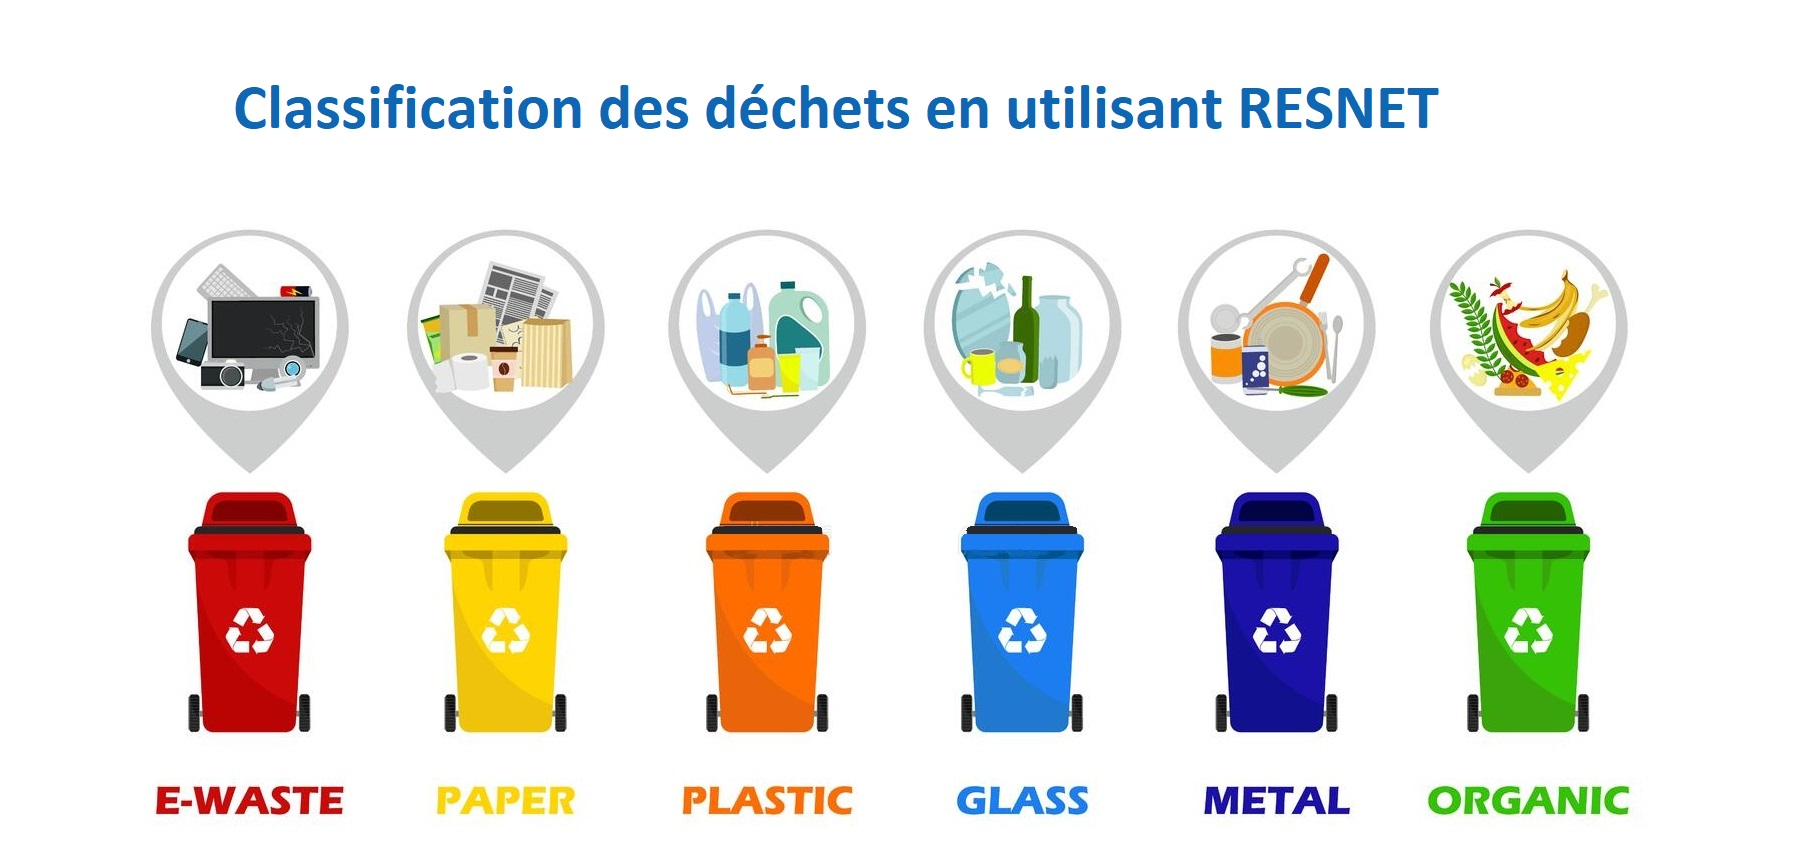

# Plan :

1. Importation des bibliothèques
2. Fonction de création d'un modèle
3. Chargement/Préparation du dataset
4. Augmentation du dataset
5. Création du fichier contenant les étiquettes
6. Exemple d'image
7. Construction/Compilation du réseau neuronale RESNET
8. La phase d'entraînement
9. Résultats
10. Évaluation 
11. Sauvegarde du modèle

# 1. Importation des bibliothèques

In [1]:
import numpy as np
import pandas as pd
import re
import os
import random

#Tensorflow + Keras et le générateur d'images + Earlystopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

#différents types de neurones
import cv2 #librairie python pour le traitement d'images
from keras.callbacks import ModelCheckpoint,EarlyStopping #callbacks, arrêt prématuré
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D 
from keras.models  import Sequential #base du réseau de neurones 

#Traitement d'image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img 
from PIL import Image

#Pour les graphes
import random,os,glob 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# 2. Fonction de création d'un modèle

In [2]:
def build_model(num_classes):
    # Loading pre-trained ResNet model
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    base_model.trainable = False
        
    return model

# 3. Chargement/Préparation du dataset

In [3]:
#chemin d'accès
file_path = '../input/manon-str-cleaned-dataset/Dataset' 
img_list = glob.glob(os.path.join(file_path, '*/*.png')) #on cherche toutes les images avec liées au chemin d'accès
print("nombre d'images :", len(img_list))

# setting the path and the labels list for classification of targets on the basis in human understandable form

train_dir = os.path.join('../input/manon-str-cleaned-dataset/Dataset')
labels = ['Carton', 'Masques', 'Metal', 'Papier', 'Plastique']

# checking the size of data available to us for training out model

for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))

nombre d'images : 51
Images of label "Carton":	 105
Images of label "Masques":	 33
Images of label "Metal":	 47
Images of label "Papier":	 42
Images of label "Plastique":	 176


# 4. Augmentation du dataset

In [4]:
#Générateur d'images
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,) #augmentations que l'on va appliquer

test=ImageDataGenerator(rescale=1/255,validation_split=0.1)

# à partir de notre fichier, création paquets de 30 images, augmentés, de taille 300/300
train_generator=train.flow_from_directory(file_path,target_size=(256,256),batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(file_path,target_size=(256,256),class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 365 images belonging to 5 classes.
Found 38 images belonging to 5 classes.
{'Carton': 0, 'Masques': 1, 'Metal': 2, 'Papier': 3, 'Plastique': 4}
{0: 'Carton', 1: 'Masques', 2: 'Metal', 3: 'Papier', 4: 'Plastique'}


# 5. Création du fichier contenant les étiquettes

In [5]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
    f.write(Labels)

{'Carton': 0, 'Masques': 1, 'Metal': 2, 'Papier': 3, 'Plastique': 4}


# 6. Exemple d'image

Metal


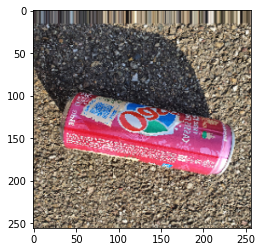

In [6]:
for image_batch, label_batch in train_generator:
    break
image_batch.shape, label_batch.shape

plt.imshow(image_batch[1])
print(labels[list(label_batch[1]).index(1)])


# 7. Construction/Compilation du réseau neuronale RESNET

In [7]:
early = EarlyStopping(monitor="val_loss",mode="min",patience=3)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.0001)

callbacks_list = [early, learning_rate_reduction]

callbacks = callbacks_list

model = build_model(num_classes=5)

9420800/9406464 [==============================] - 1s 0us/step


In [8]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = 0.001), metrics=['accuracy'])

# 8. La phase d'entraînement

In [9]:
with tf.device('/GPU:0'):
    history = model.fit(train_generator, epochs=35, verbose=1, validation_data=test_generator, callbacks=[callbacks])

Epoch 1/35
12/12 [==============================] - 81s 6s/step - loss: 1.9312 - accuracy: 0.4137 - val_loss: 1.2575 - val_accuracy: 0.4474
Epoch 2/35
12/12 [==============================] - 56s 5s/step - loss: 0.6621 - accuracy: 0.7726 - val_loss: 0.9855 - val_accuracy: 0.6053
Epoch 3/35
12/12 [==============================] - 60s 5s/step - loss: 0.3901 - accuracy: 0.8740 - val_loss: 0.9906 - val_accuracy: 0.6579
Epoch 4/35
12/12 [==============================] - 56s 5s/step - loss: 0.2337 - accuracy: 0.9260 - val_loss: 1.1047 - val_accuracy: 0.5789

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 5/35
12/12 [==============================] - 55s 5s/step - loss: 0.2092 - accuracy: 0.9260 - val_loss: 1.1486 - val_accuracy: 0.5789


# 9. Résultats

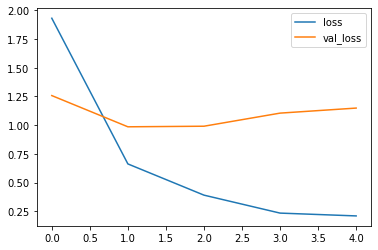

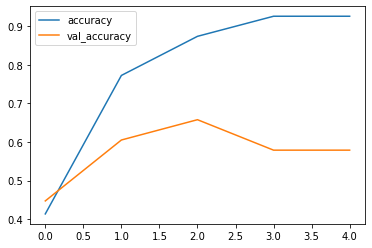

In [10]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

# 10. Évaluation 

Images of label "Carton":	 105
Images of label "Masques":	 33
Images of label "Metal":	 47
Images of label "Papier":	 42
Images of label "Plastique":	 176


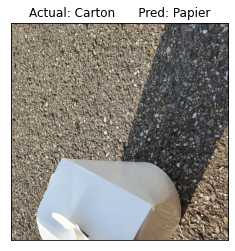

In [11]:
train_dir = os.path.join('../input/manon-str-cleaned-dataset/Dataset')
labels = ['Carton', 'Masques', 'Metal', 'Papier', 'Plastique']

for label in labels:
    directory = os.path.join(train_dir, label)
    print("Images of label \"" + label + "\":\t", len(os.listdir(directory)))
    
#cat = int(input('Enter any category by index: '))
#ind = int(input('Enter any index to test: '))

cat = 0
ind = 0

directory = os.path.join(train_dir, labels[cat % 6])
try:
    path = os.path.join(directory, os.listdir(directory)[ind])
    img = mpimg.imread(path)
    x = keras.preprocessing.image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = model.predict(images)
    pred = labels[np.argmax(classes)]
    
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title('Actual: {}      Pred: {}'.format(labels[cat], pred))
    
except:
    print('Invalid Value')

# 11. sauvegarde du modèle

In [12]:
model.save('Model-RESNET-Classification-déchets.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
